<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v4)
Here I'm looking at formulising the idea of using the model to occasionally regenerate the training data input maps.

In [322]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git checkout feature/20241108-dataset-revisor
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
import slam_data_test
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)
reload(slam_data_test)

HEAD is now at 6b93172 TF AutoGraph compatible functions
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 4), reused 4 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 1.04 KiB | 96.00 KiB/s, done.
From https://github.com/malcolmlett/robovac
   6b93172..b6dc320  feature/20241108-dataset-revisor -> origin/feature/20241108-dataset-revisor
Already on 'feature/20241108-dataset-revisor'
Your branch is behind 'origin/feature/20241108-dataset-revisor' by 2 commits, and can be fast-forwarded.
  (use "git pull" to update your local branch)
Updating 6b93172..b6dc320
Fast-forward
 slam_data.py | 42 +++++++++++++++++++++++-------------------
 1 file changed, 23 insertions(+), 19 deletions(-)


<module 'slam_data_test' from '/content/repo/slam_data_test.py'>

In [6]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
import gc
import datetime
from timeit import default_timer as timer

In [23]:
# Load floorplan
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")
floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


In [7]:
# Load training data
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data4.npz')

Loaded:
  input_maps:  (1000, 159, 159, 3) x float32
  lds_maps:    (1000, 159, 159) x float32
  output_maps: (1000, 159, 159, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data4.npz


In [9]:
# Load initial model
model = tf.keras.models.load_model('experimental-slam-model3-50epochs.keras')

## Baseline
Simple dataset iteration


In [17]:
# iterating one sample at a time
for i in range(10):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in train_data:
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

iterated 1000 times in duration: 0.7834749649999821 sec
iterated 1000 times in duration: 1.269631411999967 sec
iterated 1000 times in duration: 1.2621177610000132 sec
iterated 1000 times in duration: 0.595169118000058 sec
iterated 1000 times in duration: 0.5715427000000091 sec
iterated 1000 times in duration: 0.5782982860000629 sec
iterated 1000 times in duration: 0.561475492999989 sec
iterated 1000 times in duration: 0.58194446899995 sec
iterated 1000 times in duration: 0.5658674630000178 sec
iterated 1000 times in duration: 0.5817690799999582 sec


In [21]:
# iterating by batch
for i in range(10):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in train_data.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

iterated 32 times in duration: 0.9040662400000201 sec
iterated 32 times in duration: 0.8873992680000811 sec
iterated 32 times in duration: 0.909232220000149 sec
iterated 32 times in duration: 0.8513878879998629 sec
iterated 32 times in duration: 1.15368658400007 sec
iterated 32 times in duration: 0.8604072799998903 sec
iterated 32 times in duration: 1.2438625770000726 sec
iterated 32 times in duration: 1.4393202530000053 sec
iterated 32 times in duration: 1.2760684769998534 sec
iterated 32 times in duration: 0.9461815779998233 sec


In [30]:
# iteration with map function
print(f"Setting new mapped dataset each time")
for i in range(10):
  start = timer()
  count = 0
  ds = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))
  for (input_map, lds_map), (output_map, output_adlo) in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

print(f"Sharing mapped dataset")
ds = train_data.map(lambda inputs, outputs, metadata: (inputs, outputs))
for i in range(10):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo) in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

Setting new mapped dataset each time
iterated 1000 times in duration: 1.2496755590000248 sec
iterated 1000 times in duration: 1.2010540060000494 sec
iterated 1000 times in duration: 1.2241165389998514 sec
iterated 1000 times in duration: 1.8238477639999928 sec
iterated 1000 times in duration: 2.114683045999982 sec
iterated 1000 times in duration: 1.206054215999984 sec
iterated 1000 times in duration: 1.1951814910000849 sec
iterated 1000 times in duration: 1.190226536999944 sec
iterated 1000 times in duration: 1.1607141529998444 sec
iterated 1000 times in duration: 1.1735059329998876 sec
Sharing mapped dataset
iterated 1000 times in duration: 1.1694766000000527 sec
iterated 1000 times in duration: 0.6287542140003097 sec
iterated 1000 times in duration: 0.6277864210001098 sec
iterated 1000 times in duration: 0.6305799439996917 sec
iterated 1000 times in duration: 0.6140578299996378 sec
iterated 1000 times in duration: 1.268923518000065 sec
iterated 1000 times in duration: 1.2712989060000

In [22]:
gc.collect()

612

## Dataset Revisor
Verify that it's basically working

In [24]:
revisor = slam_data.DatasetRevisor(floorplan, model)

In [25]:
revisor.prepare()

Generating 85 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 14s/step


In [233]:
print("Prepared:")
print(f"sample_locations: {revisor._sample_locations.shape} x {revisor._sample_locations.dtype}")
print(f"sample_maps:      {revisor._sample_maps.shape} x {revisor._sample_maps.dtype}")


Prepared:
sample_locations: (85, 2) x float64
sample_maps:      (85, 149, 149, 3) x <dtype: 'float32'>


input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 7.7704326e+03 5.2244917e+03 2.2490387e+00]


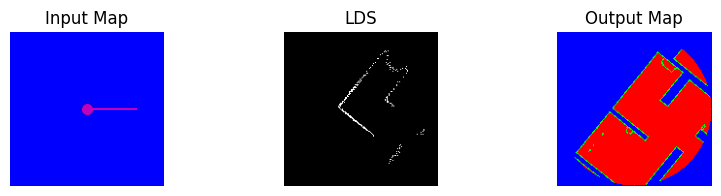

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.06650611 -0.1320825  -0.31531525]
metadata:   [2.0000000e+00 2.0000000e+00 1.2393085e+04 1.5160209e+03 0.0000000e+00
 1.2865870e+04 5.7706079e+02 2.2837534e+00]


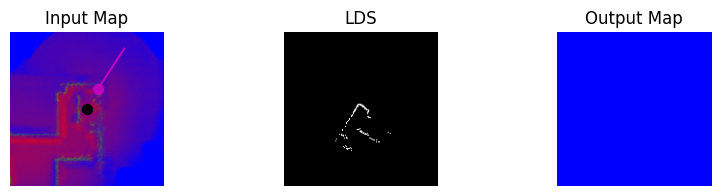

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.          0.08753846  0.48659375 -0.07261062]
metadata:   [2.0000000e+00 2.0000000e+00 5.3261099e+03 1.4369366e+03 0.0000000e+00
 5.9484111e+03 4.8960781e+03 1.1705631e+00]


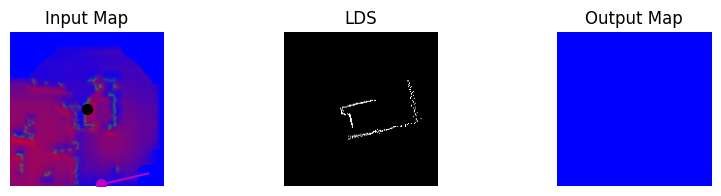

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.1377892e+04 1.6338907e+03 2.9138200e+00]


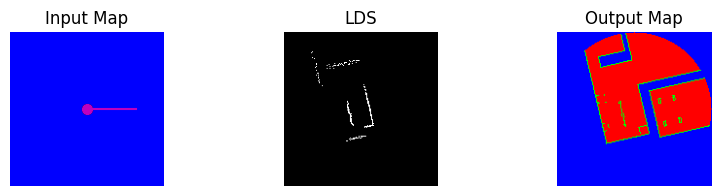

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.         -0.04257149 -0.08866958  0.0635903 ]
metadata:   [ 2.0000000e+00  1.0000000e+00  3.1065562e+03  5.0983755e+03
  0.0000000e+00  2.8039202e+03  4.4680332e+03 -4.6301708e-01]


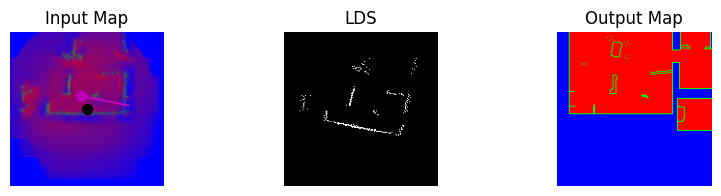

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.1949268e+03  1.1775712e+03 -1.0998367e+00]


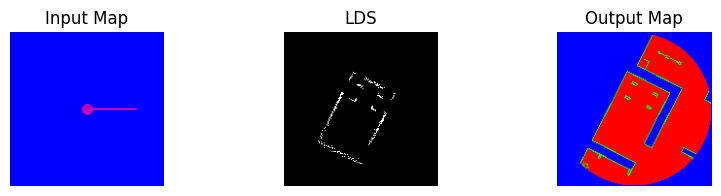

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
metadata:   [ 2.0000000e+00  1.0000000e+00  1.1190451e+04  2.4545078e+03
  0.0000000e+00  1.1187198e+04  2.5997571e+03 -5.7919192e-01]


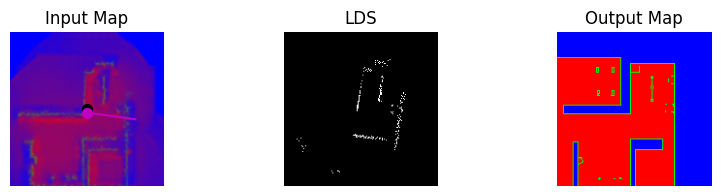

input_map:  (159, 159, 3)
lds_map:    (159, 159)
output_map: (159, 159, 3)
adlo:       [ 1.         -0.02623202 -0.06905483  0.02933878]
metadata:   [2.0000000e+00 1.0000000e+00 9.9319688e+03 6.1553672e+03 0.0000000e+00
 9.7454883e+03 5.6644639e+03 5.9592706e-01]


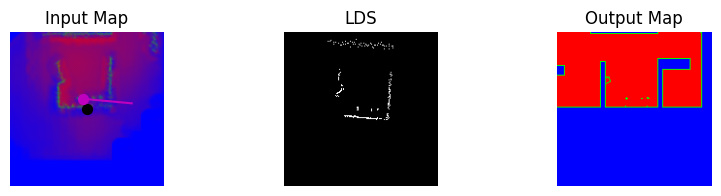

In [370]:
#ds = train_data.map(revisor.map)
reload(slam_data)

@tf.function
def revisor_map(inputs, outputs, metadata):
    """
    Passed as a function to TF.Dataset.map()
    """
    (input_map, lds_map) = inputs
    (output_map, output_adlo) = outputs

    # skip if input_map is blanked out
    unknown_min = tf.reduce_min(input_map[..., slam_data.__UNKNOWN_IDX__])
    if unknown_min == 1.0:
        return (input_map, lds_map), (output_map, output_adlo), metadata

    map_centre = metadata[2:4]  # x,y, units: physical
    map_orientation = metadata[4]
    size_px = input_map.shape[0:2]
    tf.debugging.assert_equal(
        map_orientation, 0.0,
        message=f"Only supports zero-degrees oriented maps, found: {map_orientation}")

    new_input_map = slam_data.pre_sampled_crop(
        map_centre, size_px, sample_locations, sample_maps,
        sampling_mode='centre-first', max_samples=5)

    return (new_input_map, lds_map), (output_map, output_adlo), metadata

ds = train_data.map(revisor_map)

slam_data.show_dataset(ds, num=8)

In [371]:
# checking performance
# iteration with map function
print(f"Setting new mapped dataset each time")
for i in range(4):
  start = timer()
  count = 0
  ds = train_data.map(revisor_map)
  for (input_map, lds_map), (output_map, output_adlo), metadata in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

print(f"Sharing mapped dataset")
ds = train_data.map(revisor_map)
for i in range(4):
  start = timer()
  count = 0
  for (input_map, lds_map), (output_map, output_adlo), metadata in ds.batch(32):
      count += 1
  duration = (timer() - start)
  print(f"iterated {count} times in duration: {duration} sec")

Setting new mapped dataset each time
iterated 32 times in duration: 11.778141270999186 sec
iterated 32 times in duration: 21.351156109998556 sec
iterated 32 times in duration: 21.494693885000743 sec
iterated 32 times in duration: 11.698418590000074 sec
Sharing mapped dataset
iterated 32 times in duration: 12.92947062500025 sec
iterated 32 times in duration: 9.844602057000884 sec
iterated 32 times in duration: 21.28532696199909 sec
iterated 32 times in duration: 21.286555218001013 sec


## Model training with dataset revisor

## Appendix: Revising slam_data functions for TF autograph
Some functions need to be TF autograph compatible in order to be used as part of the dataset pipeline:
* `pre_sampled_crop()`
* `combine_semantic_maps()`
* `get_intersect_ranges()`
* `_map_shape()`

In [40]:
# data prep (if already available)
sample_locations = revisor._sample_locations
sample_maps = revisor._sample_maps
print(f"sample_locations: {sample_locations.shape} x {sample_locations.dtype}")
print(f"sample_maps:      {sample_maps.shape} x {sample_maps.dtype}")

sample_locations: (85, 2) x float64
sample_maps:      (85, 149, 149, 3) x <dtype: 'float32'>


In [ ]:
# _map_shape()
# --> scrapping in favour of inlining into get_interset_ranges_tf()

In [323]:
# TF version of get_intersect_ranges()
slam_data_test.run_test_suite()
ranges = slam_data.get_intersect_ranges_tf(tf.constant((139, 294)), tf.constant((139, 294)), tf.constant((10, 10)))
print(f"range A: {ranges[0].shape} = {tf.reduce_min(ranges[0],axis=(0,1))} - {tf.reduce_max(ranges[0],axis=(0,1))}")
print(f"range B: {ranges[1].shape} = {tf.reduce_min(ranges[1],axis=(0,1))} - {tf.reduce_max(ranges[1],axis=(0,1))}")

range A: (129, 284, 2) = [10 10] - [138 293]
range B: (129, 284, 2) = [0 0] - [128 283]


locs: <class 'tensorflow.python.framework.ops.EagerTensor'> = (4, 2) x <dtype: 'float64'>
maps: <class 'tensorflow.python.framework.ops.EagerTensor'> = (4, 149, 149, 3) x <dtype: 'float32'>
Any output range:
  start: [   44.71 -2190.79]
  combined: (236, 310, 3) x <dtype: 'float32'> in range [0.        0.        0.1783238] - [0.7763947  0.57274693 1.        ]
  sum: (236, 310) in range 0.9999998807907104 - 1.0000001192092896
Specified output range:
  start: [2235.5     -447.09998]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.        0.        0.1783238] - [0.7763947 0.5461913 1.       ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896


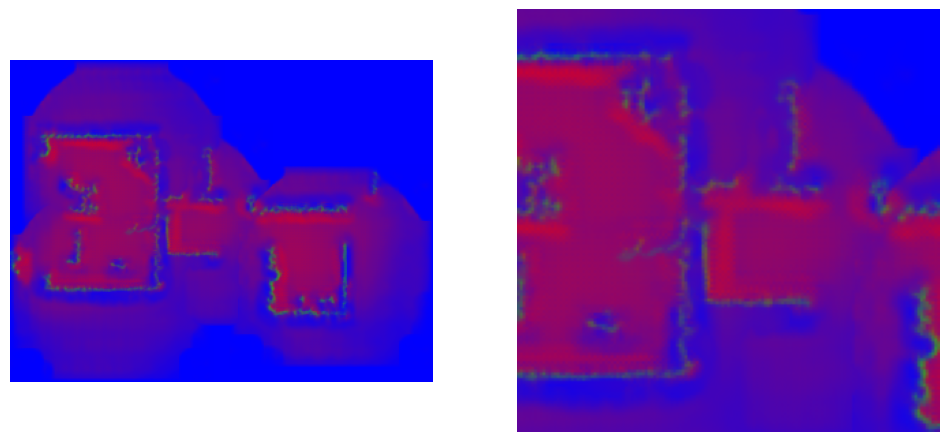

In [324]:
# TF compatible combine_semantic_maps()
reload(slam_data)
indices = 0, 1, 2, 3
locs = tf.gather(sample_locations, indices)
maps = tf.gather(sample_maps, indices)
print(f"locs: {type(locs)} = {locs.shape} x {locs.dtype}")
print(f"maps: {type(maps)} = {maps.shape} x {maps.dtype}")


def verify(combined, start):
  print(f"  start: {start}")
  print(f"  combined: {combined.shape} x {combined.dtype} in range {tf.reduce_min(combined, axis=(0,1))} - {tf.reduce_max(combined, axis=(0,1))}")
  sm = tf.reduce_sum(combined, axis=-1)
  print(f"  sum: {sm.shape} in range {tf.reduce_min(sm)} - {tf.reduce_max(sm)}")


print(f"Any output range:")
combined1, start1 = slam_data.combine_semantic_maps(locs, maps)
verify(combined1, start1)

print(f"Specified output range:")
out_range = np.array([50, -10, 149, 149])
combined2, start2 = slam_data.combine_semantic_maps(locs, maps, output_range_px=out_range)
verify(combined2, start2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(combined1)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(combined2)
plt.axis('off')
plt.show()


In [325]:
reload(slam_data)
def verify(combined, start):
  print(f"  start: {start}")
  print(f"  combined: {combined.shape} x {combined.dtype} in range {tf.reduce_min(combined, axis=(0,1))} - {tf.reduce_max(combined, axis=(0,1))}")
  sm = tf.reduce_sum(combined, axis=-1)
  print(f"  sum: {sm.shape} in range {tf.reduce_min(sm)} - {tf.reduce_max(sm)}")

for i in range(10):
  indices = tf.random.shuffle(tf.range(20))[:3]
  locs = tf.gather(sample_locations, indices)
  maps = tf.gather(sample_maps, indices)

  output_range_px = tf.random.uniform(shape=(2,), minval=-10, maxval=100, dtype=tf.int32)
  output_range_px = [output_range_px[0], output_range_px[1], 149, 149]

  print(f"indices: {indices}")
  combined1, start1 = slam_data.combine_semantic_maps(locs, maps, output_range_px=output_range_px)
  verify(combined1, start1)


indices: [ 2 10  6]
  start: [1430.72   2950.8599]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.18668014] - [0.7169624 0.423033  1.       ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [17 18  3]
  start: [ -44.71   2414.3398]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.18587267] - [0.7781585 0.4881626 1.       ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [ 2 13 19]
  start: [4113.32 2280.21]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.18668014] - [0.7296207  0.45407522 1.        ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [11  0 19]
  start: [-357.68 1743.69]
  combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.17111194] - [0.77630776 0.5357618  1.        ]
  sum: (149, 149) in range 0.9999998807907104 - 1.0000001192092896
indices: [10  0  2]
  start: [

combined: (149, 149, 3) x <dtype: 'float32'> in range [0.         0.         0.15455103] - [0.8097343  0.45294347 1.        ]


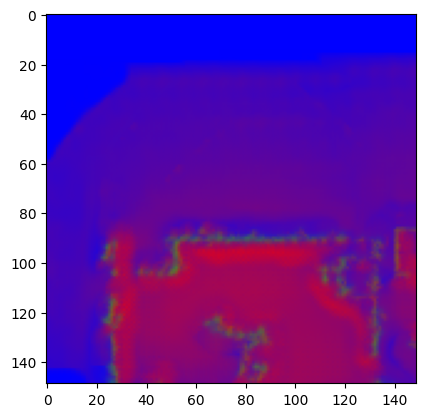

In [337]:
# TF compatible pre_sampled_crop()
centre = tf.constant([50.0, -10.0]) * lds.__PIXEL_SIZE__
size_px = tf.constant([149, 149])
combined = slam_data.pre_sampled_crop(centre, size_px, sample_locations, sample_maps, sampling_mode='centre-first', max_samples=5)
print(f"combined: {combined.shape} x {combined.dtype} in range {tf.reduce_min(combined, axis=(0,1))} - {tf.reduce_max(combined, axis=(0,1))}")
plt.imshow(combined)
plt.show()